In [1]:
# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
import pandas as pd

# tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# imaging
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

tf.__version__: 2.8.0
keras.__version__: 2.8.0


In [27]:
def load_training():

    labels = pd.read_csv('data/training_norm.csv')

    images_dir = 'data/training_data/'

    X = []
    Y = []

    pattern = '*.png'
    for label in labels.itertuples():
        filename = str(label.image_id) + '.png'

        if fnmatch.fnmatch(filename, pattern):
            X.append(os.path.join(images_dir, filename))
            Y.append([label.angle, label.speed])

    return X, Y

In [28]:
def load_test():
    images_dir = 'data/test_data/'
    filenames = os.listdir(images_dir)

    paths = []
    for filename in filenames:
        if fnmatch.fnmatch(filename, '*.png'):
            paths.append(os.path.join(images_dir, filename))

    return paths

In [29]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(2, activation='sigmoid'))
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Adam(learning_rate=1e-3) # lr is learning rate
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

model = nvidia_model()
print(model.summary())

Model: "Nvidia_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 dropout_2 (Dropout)         (None, 3, 20, 64)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten_1 (Flatten)         (None, 1152)             

In [30]:
# Preprocess images for NVIDIA model.
def img_preprocess(image):
    height, _, _ = image.shape
    #image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relevant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing
    return image

def read_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def image_data_generator(image_paths, angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []

        # This works with batches of random images. 
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)

            batch_steering_angles.append(angles[random_index])
              
            image = read_image(image_paths[random_index])
            image = img_preprocess(image)
            batch_images.append(image)
            
        yield(np.asarray(batch_images), np.asarray(batch_steering_angles))


In [31]:
model_output_dir = 'model_output/'

In [32]:
# saves the model weights after each epoch if the validation loss decreased
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir, 'lane_navigation_check.h5'), verbose=1, save_best_only=True)

x, y = load_training()

history = model.fit(image_data_generator(x, y, batch_size=32, is_training=True),
                              steps_per_epoch=300,
                              epochs=10,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir,'lane_navigation_final.h5'))

Epoch 1/10
300/300 [==============================] - 51s 167ms/step - loss: 0.0866
Epoch 2/10
300/300 [==============================] - 48s 161ms/step - loss: 0.0505
Epoch 3/10
300/300 [==============================] - 48s 159ms/step - loss: 0.0395
Epoch 4/10
300/300 [==============================] - 46s 155ms/step - loss: 0.0352
Epoch 5/10
300/300 [==============================] - 46s 152ms/step - loss: 0.0328
Epoch 6/10
300/300 [==============================] - 45s 151ms/step - loss: 0.0310
Epoch 7/10
300/300 [==============================] - 46s 153ms/step - loss: 0.0269
Epoch 8/10
300/300 [==============================] - 45s 151ms/step - loss: 0.0268
Epoch 9/10
300/300 [==============================] - 45s 151ms/step - loss: 0.0271
Epoch 10/10
300/300 [==============================] - 45s 150ms/step - loss: 0.0237


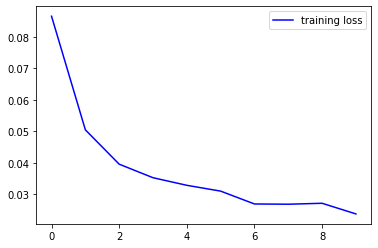

In [33]:
plt.plot(history.history['loss'],color='blue')
plt.legend(["training loss", ])

In [60]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/lane_navigation_final.h5')
    prediction = model.predict(X)
    summarize_prediction(Y, prediction)
    return prediction

x, y = load_training()

n_tests = 100
x_test, y_test = next(image_data_generator(x, y, n_tests, False))
y_pred = predict_and_summarize(x_test, y_test)

mse       = 0.011
r_squared = 73.06%


In [61]:
model = load_model(f'{model_output_dir}/lane_navigation_final.h5')
        
def compute_steering_angle(model, frame):
    preprocessed = img_preprocess(frame)
    X = np.asarray([preprocessed])
    return model.predict(X)[0]

x_test = load_test()

predicted_angles = []
predicted_speeds = []
image_ids = []
for image_path in x_test:
    print(f'Processing Image: {image_path}')
    prediction = compute_steering_angle(model, read_image(image_path))
    predicted_angles.append(prediction[0])

    if prediction[1] < 0.5:
        predicted_speeds.append(0)
    else:
        predicted_speeds.append(1)
    image_ids.append(os.path.basename(image_path).split('.')[0])


Processing Image: data/test_data/348.png
Processing Image: data/test_data/412.png
Processing Image: data/test_data/374.png
Processing Image: data/test_data/360.png
Processing Image: data/test_data/406.png
Processing Image: data/test_data/638.png
Processing Image: data/test_data/176.png
Processing Image: data/test_data/88.png
Processing Image: data/test_data/610.png
Processing Image: data/test_data/604.png
Processing Image: data/test_data/162.png
Processing Image: data/test_data/189.png
Processing Image: data/test_data/837.png
Processing Image: data/test_data/77.png
Processing Image: data/test_data/823.png
Processing Image: data/test_data/63.png
Processing Image: data/test_data/980.png
Processing Image: data/test_data/758.png
Processing Image: data/test_data/994.png
Processing Image: data/test_data/764.png
Processing Image: data/test_data/770.png
Processing Image: data/test_data/943.png
Processing Image: data/test_data/957.png
Processing Image: data/test_data/228.png
Processing Image: d

In [48]:
data = {
    'image_id': image_ids,
    'angle': predicted_angles,
    'speed': predicted_speeds
}
results = pd.DataFrame(data)

In [49]:
results.to_csv('results.csv', index=False)

In [51]:
print(results.at[20, 'image_id'])
print(results.at[20, 'angle'])
results.at[20, 'speed']

770
0.50245774


0